Model previously downloaded!
[[2.7520132 2.7520695 2.7522106 ... 2.2429442 2.2428577 2.2428234]
 [2.7519572 2.752013  2.7521532 ... 2.242909  2.2428231 2.242789 ]
 [2.7518182 2.7518725 2.7520094 ... 2.2428207 2.242737  2.242704 ]
 ...
 [2.1980946 2.1980414 2.1979074 ... 2.0813298 2.0810537 2.080945 ]
 [2.1979604 2.1979067 2.197772  ... 2.0816352 2.0813453 2.0812306]
 [2.1979067 2.1978528 2.1977184 ... 2.0817583 2.081463  2.0813463]]
running deeplab on Cat_and_Dog.jpg...


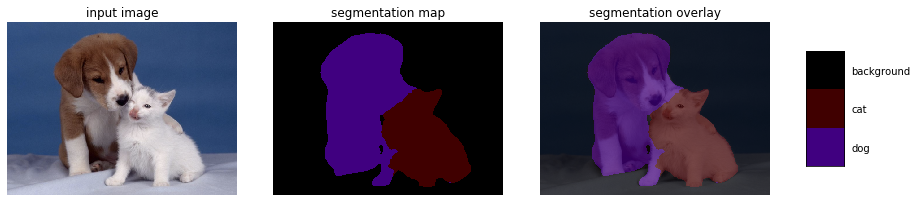

running deeplab on Bike.jpg...


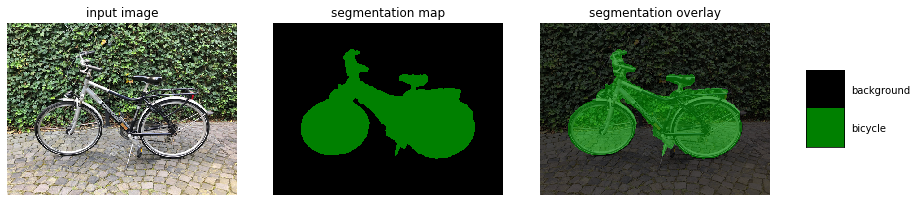

running deeplab on Bottles.jpg...


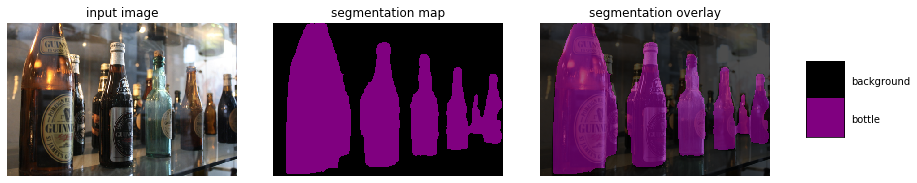

running deeplab on F1_car.jpg...


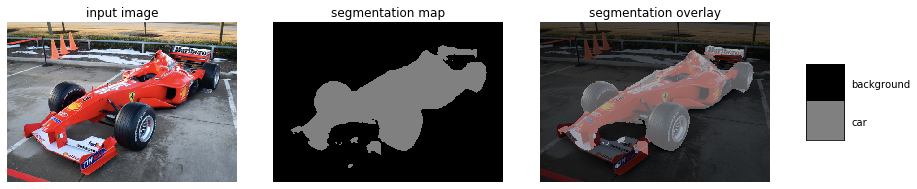

running deeplab on Bird.jpg...


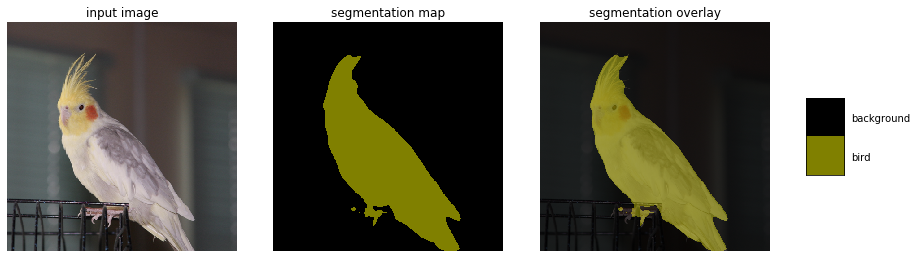

running deeplab on Student_Painting.jpg...


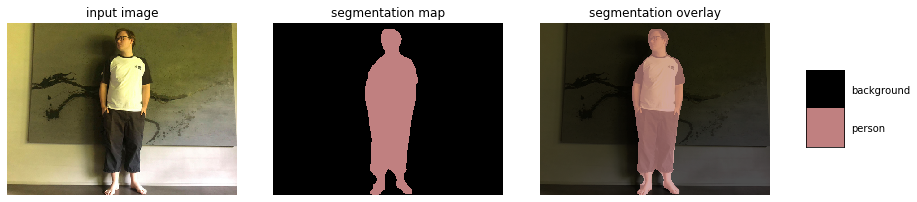

running deeplab on Garden_Table.jpg...


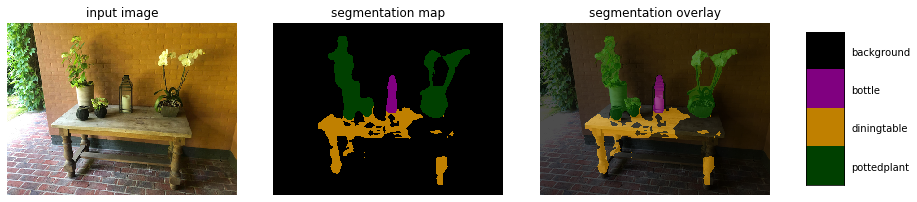

running deeplab on Office.jpg...


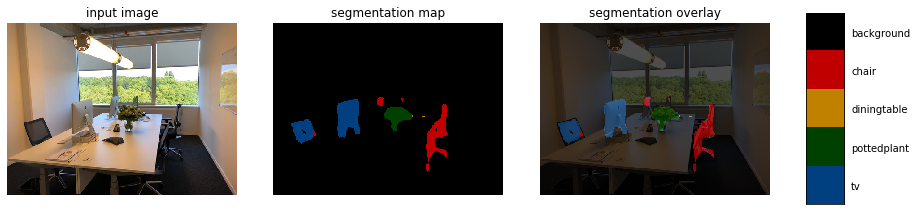

In [4]:
#William Herbosch - UCL Research Project 2018-19 - Virtual Annotator System
#RGB Images to Segmented Images via Tensorflow/DeepLab
#
#Formal licensing and credit: 
#This code is not wholly the student's own work. 
#This code was written on the basis of the work of its original author, Antonio Verdone - University of Edinburgh
#This code is not an exact copy of his code; while the basis of his code is present, some lines have been removed/altered to better fit the demands of the project.
#Antonio's original code can be viewed here for comparison: https://averdones.github.io/real-time-semantic-image-segmentation-with-deeplab-in-tensorflow/

## Imports
import collections  #Creates tuples 
import os  #Operating System operators 
import sys  #Needed for pathing and directory locating 
import tarfile  #Read and write zip files
import tempfile  #Generate temp files and directories 
import urllib  #Fetching data across the WWW
from IPython import display  #Needed for dropdown menu
from ipywidgets import interact  #Needed for the dropdown menu
from ipywidgets import interactive  #Needed for the dropdown menu
from matplotlib import gridspec  #Needed for plotting the colourmap
from matplotlib import pyplot as plt  #Needed for plotting the images
import numpy as np  #Numerical computations
from PIL import Image  #Python Image Library Operator
import tensorflow as tf  #Machine Learning Library

#Needed for reading files in test directory
from os import listdir
from os.path import isfile, join

# Needed to show segmentation colormap labels
sys.path.append('utils')
import get_dataset_colormap

##############################################################################################################################
## SETTINGS. PLEASE READ:  

#Boolean check if network is to predict for a single image (True) or all images (False) within a directory:
single_image = False

#Boolean check if image(s) are placed openly in ../TestImages/* (True) or are within a sub-directory (False):
sub_directory = False

#Name of the directory folder placed within ../deeplab/g3doc/img/TestImages/*
#This will only be set if sub_directory == True:
test_image_directory = 'THETestImages'

#Boolean check if model needs to be downloaded. 
#Also used for saving memory by clearing the same figure each time rather than make new ones. 
#IMPORTANT!!! If running code for first time, download model = True. Else and on subsequent runs of program, = False:
download_model = False

#Boolean check to view the images:
show_images = True

##############################################################################################################################

## Select and download models
#For the purpose of the project, only using trainaug, not trainval
_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
}

#Configure the model to train from and the directory to read it from
Config = collections.namedtuple('Config', 'model_url, model_dir')
def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)
if download_model == True:
    config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')
    display.display(config_widget)

# Check configuration and download the model
_TARBALL_NAME = 'deeplab_model.tar.gz'

#Unzip the model
config = config_widget.result
model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

#Download code
if download_model == True:
    download_path = os.path.join(model_dir, _TARBALL_NAME)
    print('downloading model to %s, this might take a while...' % download_path)
    urllib.request.urlretrieve(config.model_url, download_path)
    print('download completed!')
else: 
    print('Model previously downloaded!')

#Testing for importing .mat data (i.e. the depth maps) into python as arrays    
import scipy.io #For reading in the depth images
mat = scipy.io.loadmat('g3doc/img/TestImages/NYU_Depths/NYU_DepthMap_1.mat')
list_values = [v for v in mat.values()]
this_depth_map = list_values[3]
print(this_depth_map)
   
## Load model in TensorFlow
_FROZEN_GRAPH_NAME = 'frozen_inference_graph'

#Train the deeplab model
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    #Initialize the model
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)
    #Run the model
    def run(self, image):
        """Runs inference on a single image.
        Args:
            image: A PIL.Image object, raw input image.
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        #Dimensions of the image
        width, height = image.size
        #Rescale image in accordance to model input size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        #Batch segmentation
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map
#Set the model
model = DeepLabModel(download_path)


## Helper methods: the different identifiers for the colour map
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

#Labels and colourmap
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)

#Visualise the output images
def vis_segmentation(image, seg_map, image_name):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    #Segmented Image
    plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    plt.imshow(seg_image)
    #Save Segmented Image
    segim = Image.fromarray(seg_image)
    my_path = os.path.abspath('/Users/williamherbosch/tensorflow/models/research/deeplab/g3doc/img/')
    
    if sub_directory == True and test_image_directory != '': #If folder of images, save in a directory of matching name within SegmentedImages
        segim.save(my_path + '/SegmentedImages/' + test_image_directory + '/' + image_name)
    if sub_directory == False: #If single image, save in SegmentedImages
        segim.save(my_path + '/SegmentedImages/' + image_name)

    plt.axis('off')
    plt.title('segmentation map')
    #Overlapped Image
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    #Colour Map Key
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)
    #Save full plot
    
    if sub_directory == True and test_image_directory != '':
        plt.savefig(my_path + '/OverlappedImages/' + test_image_directory + '/' + image_name)
    if sub_directory == False:
        plt.savefig(my_path + '/OverlappedImages/' + image_name) 
        
    if show_images == True:
        plt.show()
        
    plt.close()
    
#Note that we are using single scale inference in the demo for fast computation, 
#so the results may slightly differ from the visualizations, which uses multi-scale and left-right flipped inputs.

if sub_directory == True and test_image_directory != '': 
    IMAGE_DIR = 'g3doc/img/TestImages/' + test_image_directory #If True, extend the path name to include the sub-directory. 
if sub_directory == False:     
    IMAGE_DIR = 'g3doc/img/TestImages' #If False, no sub-directory and the data is assumed to be in the TestImages folder. 
    
#Demo the trained model on the image
def run_demo_image(image_name):
    try:
        image_path = os.path.join(IMAGE_DIR, image_name)
        orignal_im = Image.open(image_path)
    except IOError:
        print('Failed to read image from %s.' % image_path)
        return 
    print('running deeplab on %s...' % image_name)
    #Rescale the images 
    resized_im, seg_map = model.run(orignal_im)
    #Visualise the input, output and overlapped images, along with a colour map
    vis_segmentation(resized_im, seg_map, image_name)

#Obtain all file names within the test image directory
test_image_names = [f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))]
#Formatting and sorting of names
test_image_names.remove('.DS_Store')
if sub_directory == True:
    test_image_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
#For running the model on select image files within the directory:
if single_image == True:
    _ = interact(run_demo_image, image_name = test_image_names)
#For running the model on all image files within the directory:
if single_image == False:
    for i in test_image_names:
        run_demo_image(i)
